# Loss functions

**Goal:** Build up some intuition for the Hungarian loss, and how to build it in python :) 

In [25]:
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time

import collections
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import logging

tf.random.set_seed(0)

# The slot attn code
import os
os.sys.path.append('../google-research')

import slot_attention.data as data_utils
import slot_attention.model as model_utils
import slot_attention.utils as utils

from slot_attention.set_prediction.train import train_step

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
batch_size = 512
num_slots = 3
nPhotons = 2
nFeatures = 3 # (x,y,E)

y_pred = tf.random.normal((batch_size, num_slots, nFeatures))
y_true = tf.random.normal((batch_size, nPhotons,  nFeatures))

In [ ]:
?tf.losses.Huber

In [27]:
def hungarian_weighted_MSE_loss(x, y):
    """Huber loss for sets, matching elements with the Hungarian algorithm.

    This loss is used as reconstruction loss in the paper 'Deep Set Prediction
    Networks' https://arxiv.org/abs/1906.06565, see Eq. 2. For each element in the
    batches we wish to compute min_{pi} ||y_i - x_{pi(i)}||^2 where pi is a
    permutation of the set elements. We first compute the pairwise distances
    between each point in both sets and then match the elements using the scipy
    implementation of the Hungarian algorithm. This is applied for every set in
    the two batches. Note that if the number of points does not match, some of the
    elements will not be matched. As distance function we use the Huber loss.

    Args:
    x: Batch of sets of size [batch_size, n_points, dim_points]. Each set in the
      batch contains n_points many points, each represented as a vector of
      dimension dim_points.
    y: Batch of sets of size [batch_size, n_points, dim_points].

    Returns:
    Average distance between all sets in the two batches.
    """
    pairwise_cost = tf.losses.Huber(reduction=tf.keras.losses.Reduction.NONE)(
      tf.expand_dims(y, axis=-2), tf.expand_dims(x, axis=-3))
    indices = np.array(
      list(map(scipy.optimize.linear_sum_assignment, pairwise_cost)))

    transposed_indices = np.transpose(indices, axes=(0, 2, 1))

    actual_costs = tf.gather_nd(
      pairwise_cost, transposed_indices, batch_dims=1)

    return tf.reduce_mean(tf.reduce_sum(actual_costs, axis=1))

In [28]:
tf.expand_dims(y_true, axis=-2).shape

TensorShape([512, 2, 1, 3])

In [29]:
tf.expand_dims(y_pred, axis=-3).shape

TensorShape([512, 1, 3, 3])

In [30]:
mse = (tf.expand_dims(y_true, axis=-2) - tf.expand_dims(y_pred, axis=-3))**2

# Sum over the final features
MSE_manual = tf.math.reduce_mean(mse,axis=-1)
MSE_manual.shape

TensorShape([512, 2, 3])

**Goal:** Just return a single component

In [43]:
*y_true.shape[:-1],1

(512, 2, 1)

In [47]:
y_true[:,:,0,None]

<tf.Tensor: shape=(512, 2, 1), dtype=float32, numpy=
array([[[ 1.0668802 ],
        [ 0.09190083]],

       [[-2.0777557 ],
        [-0.9309037 ]],

       [[-2.761791  ],
        [ 2.0442302 ]],

       ...,

       [[-2.1454227 ],
        [-0.37080655]],

       [[ 0.20016348],
        [-0.08690415]],

       [[ 0.33077464],
        [-0.98544943]]], dtype=float32)>

In [38]:
tf.expand_dims(y_true[:,:,0], axis=-1).shape

TensorShape([512, 2, 1])

In [133]:
MSE_x = tf.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(
    tf.expand_dims(y[:,:,0,None], axis=-2), tf.expand_dims(x[:,:,0,None], axis=-3))

MSE_y = tf.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(
    tf.expand_dims(y[:,:,1,None], axis=-2), tf.expand_dims(x[:,:,1,None], axis=-3))

MSE_z = tf.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(
    tf.expand_dims(y[:,:,2,None], axis=-2), tf.expand_dims(y_pred[:,:,2,None], axis=-3))


In [155]:
MSE_0*.01

<tf.Tensor: shape=(512, 3, 2), dtype=float32, numpy=
array([[[1.97298010e-03, 2.01402009e-02],
        [4.42226268e-02, 1.27224438e-02],
        [1.16824778e-02, 1.12096655e-04]],

       [[7.16882870e-02, 2.34278180e-02],
        [8.24482515e-02, 2.97399759e-02],
        [1.38546741e-02, 9.12450741e-06]],

       [[9.39808339e-02, 3.02896332e-02],
        [1.89254642e-01, 2.07644375e-03],
        [6.66887015e-02, 4.94442210e-02]],

       ...,

       [[8.20675045e-02, 1.18837608e-02],
        [2.08213534e-02, 1.09995389e-03],
        [1.10481635e-01, 2.40021180e-02]],

       [[5.48368366e-03, 2.05618120e-03],
        [1.99491842e-04, 2.12652420e-04],
        [1.17568090e-03, 3.11524564e-05]],

       [[2.59566251e-02, 8.56926069e-02],
        [3.46650428e-04, 2.25723460e-02],
        [9.25538037e-03, 1.25440070e-03]]], dtype=float32)>

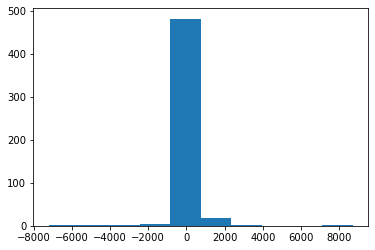

In [154]:
plt.hist(w_E[:,0,0].numpy())
plt.show()

In [141]:


tf.expand_dims(y_true[:,:,0],axis=-2)

<tf.Tensor: shape=(512, 1, 2), dtype=float32, numpy=
array([[[ 1.0668802 ,  0.09190083]],

       [[-2.0777557 , -0.9309037 ]],

       [[-2.761791  ,  2.0442302 ]],

       ...,

       [[-2.1454227 , -0.37080655]],

       [[ 0.20016348, -0.08690415]],

       [[ 0.33077464, -0.98544943]]], dtype=float32)>

In [135]:
MSE_0.shape

TensorShape([512, 3, 2])

In [53]:
(MSE_0+MSE_1+MSE_2).shape

TensorShape([512, 3, 2])

In [55]:
MSE_tf.shape

TensorShape([512, 2, 3])

In [57]:
(MSE_0+MSE_1+MSE_2) #- 

<tf.Tensor: shape=(512, 3, 2), dtype=float32, numpy=
array([[[2.6180291e-01, 2.6241853e+00],
        [7.4733086e+00, 4.3252792e+00],
        [3.4414082e+00, 4.1942496e+00]],

       [[1.6230707e+01, 2.4664023e+00],
        [1.8841488e+01, 3.4878039e+00],
        [8.1995296e+00, 1.0495462e-02]],

       [[1.2745009e+01, 8.2876396e+00],
        [2.8383703e+01, 1.7060897e+00],
        [1.6708414e+01, 6.6586094e+00]],

       ...,

       [[1.8701962e+01, 2.9306500e+00],
        [6.3532557e+00, 1.3114943e+01],
        [1.8015385e+01, 7.4408140e+00]],

       [[7.3227471e-01, 2.1263821e+00],
        [6.2131077e-01, 3.3620298e+00],
        [8.5627580e-01, 2.3422089e+00]],

       [[5.6629934e+00, 9.1265640e+00],
        [7.4243860e+00, 5.0127950e+00],
        [5.4144583e+00, 1.2189369e+00]]], dtype=float32)>

In [58]:
MSE_tf

<tf.Tensor: shape=(512, 2, 3), dtype=float32, numpy=
array([[[8.7267637e-02, 2.4911029e+00, 1.1471361e+00],
        [8.7472844e-01, 1.4417597e+00, 1.3980832e+00]],

       [[5.4102359e+00, 6.2804961e+00, 2.7331765e+00],
        [8.2213408e-01, 1.1626014e+00, 3.4984874e-03]],

       [[4.2483363e+00, 9.4612341e+00, 5.5694714e+00],
        [2.7625465e+00, 5.6869656e-01, 2.2195365e+00]],

       ...,

       [[6.2339873e+00, 2.1177518e+00, 6.0051284e+00],
        [9.7688335e-01, 4.3716474e+00, 2.4802713e+00]],

       [[2.4409157e-01, 2.0710360e-01, 2.8542528e-01],
        [7.0879406e-01, 1.1206766e+00, 7.8073627e-01]],

       [[1.8876644e+00, 2.4747953e+00, 1.8048195e+00],
        [3.0421879e+00, 1.6709317e+00, 4.0631232e-01]]], dtype=float32)>

In [32]:
tf.reduce_max(MSE_manual - MSE_tf)

<tf.Tensor: shape=(), dtype=float32, numpy=1.9073486e-06>

OK, I understand what this function is doing (up to floating point errors!!

In [9]:
Huber_tf = tf.losses.Huber(reduction=tf.keras.losses.Reduction.NONE)(
    tf.expand_dims(y_true, axis=-2), tf.expand_dims(y_pred, axis=-3))
Huber_tf.shape

TensorShape([512, 2, 3])

In [10]:
tf.losses.Huber

keras.losses.Huber

In [11]:
from scipy.optimize import linear_sum_assignment

`linear_sum_assignment` solves the problem of minimizing a cost matrix

In [12]:
?linear_sum_assignment

Signature: linear_sum_assignment(cost_matrix, maximize=False)
Docstring:
Solve the linear sum assignment problem.

The linear sum assignment problem is also known as minimum weight matching
in bipartite graphs. A problem instance is described by a matrix C, where
each C[i,j] is the cost of matching vertex i of the first partite set
(a "worker") and vertex j of the second set (a "job"). The goal is to find
a complete assignment of workers to jobs of minimal cost.

Formally, let X be a boolean matrix where :math:`X[i,j] = 1` iff row i is
assigned to column j. Then the optimal assignment has cost

.. math::
    \min \sum_i \sum_j C_{i,j} X_{i,j}

where, in the case where the matrix X is square, each row is assigned to
exactly one column, and each column to exactly one row.

This function can also solve a generalization of the classic assignment
problem where the cost matrix is rectangular. If it has more rows than
columns, then not every row needs to be assigned to a column, and vice
vers

In [13]:
?linear_sum_assignment

Signature: linear_sum_assignment(cost_matrix, maximize=False)
Docstring:
Solve the linear sum assignment problem.

The linear sum assignment problem is also known as minimum weight matching
in bipartite graphs. A problem instance is described by a matrix C, where
each C[i,j] is the cost of matching vertex i of the first partite set
(a "worker") and vertex j of the second set (a "job"). The goal is to find
a complete assignment of workers to jobs of minimal cost.

Formally, let X be a boolean matrix where :math:`X[i,j] = 1` iff row i is
assigned to column j. Then the optimal assignment has cost

.. math::
    \min \sum_i \sum_j C_{i,j} X_{i,j}

where, in the case where the matrix X is square, each row is assigned to
exactly one column, and each column to exactly one row.

This function can also solve a generalization of the classic assignment
problem where the cost matrix is rectangular. If it has more rows than
columns, then not every row needs to be assigned to a column, and vice
vers

In [14]:
idx_rows, idx_cols = linear_sum_assignment(MSE_tf[0])
idx_rows, idx_cols

(array([0, 1]), array([0, 2]))

**Output:** Array of row indices and column indices corresponding to the optimal assignment

In [15]:
MSE_tf[0]

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.08726764, 2.491103  , 1.1471361 ],
       [0.87472844, 1.4417597 , 1.3980832 ]], dtype=float32)>

OK, based on looking at this, I think was `linear_sum_assignment` returns the row and column indices for the adjacency matrix that solves this bipartite graph matching problem.

In [16]:
# Let X be shape (2,3) be the adjacency matrix
X = np.zeros_like(MSE_tf[0])
X[idx_rows, idx_cols] = 1

In [17]:
X

array([[1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [18]:
np.sum(X * MSE_tf[0].numpy())

1.4853508

In [19]:
indices = np.array( list(map(linear_sum_assignment, MSE_tf)) )

In [20]:
indices.shape

(512, 2, 2)

In [21]:
indices[0]

array([[0, 1],
       [0, 2]])

(I think) the output becomes a bit more transparent when we take the transpose (which is in fact what they're doing in the loss function calculation.

In [22]:
transposed_indices = np.transpose(indices, axes=(0, 2, 1))

In [23]:
transposed_indices[0]

array([[0, 0],
       [1, 2]])

**What does this mean?**
- Worker (truth particle) 0 matches to job (slot) 0
- Worker (truth particle) 1 matches to job (slot) 2


In [24]:
?tf.gather_nd

Signature: tf.gather_nd(params, indices, batch_dims=0, name=None)
Docstring:
Gather slices from `params` into a Tensor with shape specified by `indices`.

`indices` is an K-dimensional integer tensor, best thought of as a
(K-1)-dimensional tensor of indices into `params`, where each element defines
a slice of `params`:

    output[\\(i_0, ..., i_{K-2}\\)] = params[indices[\\(i_0, ..., i_{K-2}\\)]]

Whereas in `tf.gather` `indices` defines slices into the first
dimension of `params`, in `tf.gather_nd`, `indices` defines slices into the
first `N` dimensions of `params`, where `N = indices.shape[-1]`.

The last dimension of `indices` can be at most the rank of
`params`:

    indices.shape[-1] <= params.rank

The last dimension of `indices` corresponds to elements
(if `indices.shape[-1] == params.rank`) or slices
(if `indices.shape[-1] < params.rank`) along dimension `indices.shape[-1]`
of `params`.  The output tensor has shape

    indices.shape[:-1] + params.shape[indices.shape[-1]:]

Ad

In [86]:
y_pred[0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 1.5110626 ,  0.42292207, -0.41969493],
       [-1.0360373 , -1.2368279 ,  0.47027302],
       [-0.01397488,  1.1888583 ,  0.60253334]], dtype=float32)>

In [67]:
transposed_indices[0][:,1]

array([0, 2])

In [74]:
y_pred.shape

TensorShape([512, 3, 3])

In [96]:
tf.expand_dims(transposed_indices[0][:,1],axis=-2)

<tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[0, 2]])>

In [101]:
tf.expand_dims(transposed_indices[:,:,1],axis=-2).shape

TensorShape([512, 1, 2])

In [106]:
y_pred.shape

TensorShape([512, 3, 3])

In [110]:
tf.expand_dims(transposed_indices[:,:,1],axis=-1).shape

TensorShape([512, 2, 1])

In [131]:
test_out = tf.gather_nd(y_pred, tf.expand_dims(transposed_indices[:,:,1],axis=-1), batch_dims=1)

test_out.shape

TensorShape([512, 2, 3])

In [127]:
test_out[0]

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.5110626 ,  0.42292207, -0.41969493],
       [-0.01397488,  1.1888583 ,  0.60253334]], dtype=float32)>

**What if we keep both dim of `transposed_indices`?**

In [118]:
transposed_indices.shape

(512, 2, 2)

In [119]:
y_pred.shape

TensorShape([512, 3, 3])

In [122]:
test_out = tf.gather_nd(y_pred, transposed_indices)
# test_out = tf.gather_nd(y_pred,transposed_indices)

test_out.shape

TensorShape([512, 2, 3])

In [123]:
test_out[0]

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.5110626 ,  0.42292207, -0.41969493],
       [-0.9006969 , -0.36081055, -0.22377317]], dtype=float32)>

<tf.Tensor: shape=(2, 3, 1, 3), dtype=float32, numpy=
array([[[[ 1.5110626 ,  0.42292207, -0.41969493]],

        [[-1.0360373 , -1.2368279 ,  0.47027302]],

        [[-0.01397488,  1.1888583 ,  0.60253334]]],


       [[[ 0.30383846,  0.52152544,  0.1554326 ]],

        [[ 1.5885501 , -0.7958055 ,  0.07794423]],

        [[-0.17937538, -0.85996604,  0.21930954]]]], dtype=float32)>